# Change in swell wave direction with distance
This notebook examines the measured direction of swell waves and connects it to the distance to the ice edge.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, AutoDateLocator, ConciseDateFormatter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import AutoLocator
from matplotlib import rc
from matplotlib.patches import Rectangle
import cmocean.cm as cmo

from misc import pandas_insert_with_overwrite, save_swift_as_mat_file
from plots import nice_time_axis, mark_time_range
rc('font', size = 14)

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    '''
    Source: https://stackoverflow.com/a/18926541
    '''
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    
    new_cmap = LinearSegmentedColormap.from_list(
                'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
                cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_ice_edge(ax):
    ylim = list(ax.get_ylim())
    ax.plot([0,0], ylim, '--k')
    ax.set_ylim(ylim)
    return

def boxplot(bin_centers, data):
    # Convert to km
    bin_centers__km = 1e-3 * bin_centers
    
    # Remove nan
    non_nan_data = []
    for d in data:
        non_nan_data.append(d[~np.isnan(d)])
       
    # Make boxplot        
    widths = (bin_centers__km[1]-bin_centers__km[0])
    box_plot = plt.boxplot(non_nan_data, positions = bin_centers__km, widths = widths)

    # Nicer median line
    for median in box_plot['medians']:
        median.set_color('black')
        median.set_linewidth(2)
        
    # Make x-axis nice again
    xlim = [bin_centers__km[0]-widths, bin_centers__km[-1]+widths]
    plt.xlim(xlim)
    plt.gca().xaxis.set_major_locator(AutoLocator())
    xticks = plt.xticks()[0]
    plt.xticks(ticks=xticks, labels=[str(round(tick)) for tick in xticks])
    plt.xlim(xlim)
    return

def valid_wave_direction(swift, swh_threshold):
    is_valid = (swift['sigwaveheight'] >= swh_threshold) & ~np.isnan(swift['swell.meandirT'])
    pandas_insert_with_overwrite(swift, 'end', 'valid_wave_direction', is_valid)   
    return

def time_series_scatter_plot(df, x, y, c, where, scale_c = 1,**kwargs):
    df_used = df[df[where]]
    plt.scatter(df_used[x], df_used[y], c=df_used[c]*scale_c, **kwargs)
    plt.plot(df_used[x], df_used[y], 'k', linewidth = 0.5, zorder = -1)
    return
    
def mark_southward():
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.plot(xlim, [180, 180], '-', zorder=-1, color='silver', linewidth=0.5)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.yticks(ticks=[90,135,180,225])

In [3]:
swift20_spring = pd.read_feather("../processed_data/swift20_spring.feather")
swift21_spring = pd.read_feather("../processed_data/swift21_spring.feather")

### Clean data
When the wave activity is too low, the measured wave direction will just be noise. In order to remove those data points, we use a threshold on significant wave height.

In [4]:
swh_threshold = 0.1 # m

valid_wave_direction(swift20_spring, swh_threshold)
valid_wave_direction(swift21_spring, swh_threshold)

swift = pd.concat([swift20_spring, swift21_spring], ignore_index=True)

### Swell direction plots
First, we plot the swell direction as a function of distance to the ice edge for the whole spring deployment. We will color code based on time stamp.

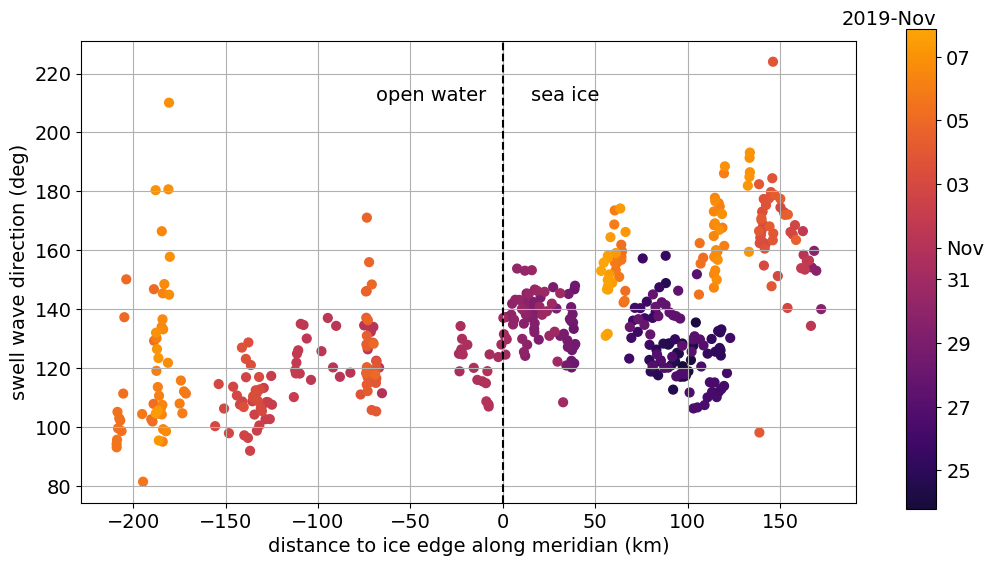

In [5]:
fig = plt.figure(figsize=(10,6))

# Create colormap
vmin = 0.1
vmax = 0.8
cmap = truncate_colormap(plt.cm.inferno, vmin, vmax)

# Make scatter plot
scatter_data = swift[swift.valid_wave_direction]
colors = date2num(scatter_data['timestamp'])
sc = plt.scatter(scatter_data['dist_meridian']*1e-3, scatter_data['swell.meandirT'], c=colors, s=40, cmap=cmap)
ax = plt.gca()

# Limits ans labels
plt.ylabel('swell wave direction (deg)')
plt.xlabel('distance to ice edge along meridian (km)')
#plt.ylim([-105,25])
plt.grid()

# Add colorbar
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = plt.colorbar(sc, cax = cbar_ax)
loc = AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(ConciseDateFormatter(loc))

# Mark ice edge
plot_ice_edge(ax)
ax.annotate('open water', xy = (0.38, 0.87), xycoords = 'axes fraction', color = 'k')
ax.annotate('sea ice', xy = (0.58, 0.87), xycoords = 'axes fraction', color = 'k')

plt.show()

The cluster of points 2019-10-24 to 2019-10-27 is collected by SWIFT20 and associated with a rapid northward movement of the ice edge and two wave events. We therefore believe that this cluster belongs to another wave field, not representative for the rest of the deployment. Apart from this cluster, a trend is seen, where the wave direction tends to be more towards the south, and thus more perpendicular to the ice edge, with increasing distance traveled in sea ice. 

In order to examine this further, we bin the data after 2019-10-27 based on distance to the ice edge, and study the wave direction and directional spread, as well as co-located sea ice concentration.

In [6]:
min_timestamp = np.datetime64('2019-10-27 23:30')
number_of_bins = 10

binned_data = {'edges': np.linspace(-2.5e5, 2.5e5, number_of_bins+1),
               'count'    : [],
               'wavedir'  : [],
               'spread'   : [],
               'sic'      : []
              }
binned_data['centers'] = 0.5 * (binned_data['edges'][:-1] + binned_data['edges'][1:])

swift_used = swift[(swift['timestamp']>min_timestamp) & swift.valid_wave_direction]
bin_index = np.digitize(swift_used['dist_meridian'], binned_data['edges'])
for i in range(1, number_of_bins+1):
    index = (bin_index == i)        
    binned_data['count'].append(sum(index))
    binned_data['wavedir'].append(swift_used.loc[index]['swell.meandirT'].values)
    binned_data['spread'].append(swift_used.loc[index]['swell.dirspread'].values)
    binned_data['sic'].append(swift_used.loc[index]['sic'].values)

### Box-and-whisker plots

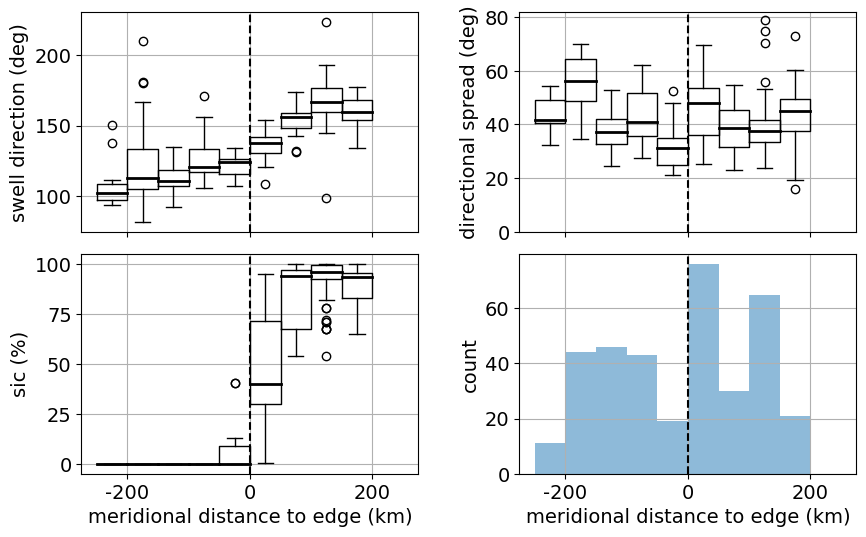

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2,
                         gridspec_kw={'wspace': 0.3,
                                      'hspace': 0.1},
                         sharex = True,
                         figsize=(10,6))

# Wave direction
plt.sca(axes[0,0])
boxplot(binned_data['centers'], binned_data['wavedir'])
plt.grid()
plot_ice_edge(axes[0,0])
axes[0,0].set_ylabel('swell direction (deg)')

# Spread
plt.sca(axes[0,1])
boxplot(binned_data['centers'], binned_data['spread'])
plt.grid()
plt.ylim([0,82])
plot_ice_edge(axes[0,1])
axes[0,1].set_ylabel('directional spread (deg)')

# Sea ice concentration
plt.sca(axes[1,0])
boxplot(binned_data['centers'], binned_data['sic'])
plot_ice_edge(axes[1,0])
plt.grid()
axes[1,0].set_xlabel('meridional distance to edge (km)')
axes[1,0].set_ylabel('sic (%)')

# Bin count
axes[1,1].hist(binned_data['centers']*1e-3, 
               bins    = len(binned_data['count']), 
               weights = binned_data['count'], 
               range   = (binned_data['edges'][0]*1e-3,binned_data['edges'][-1]*1e-3),
               alpha   = 0.5)
#axes[1,1].set_xlim([-150,150])
plot_ice_edge(axes[1,1])
axes[1,1].grid()
axes[1,1].set_xlabel('meridional distance to edge (km)')
axes[1,1].set_ylabel('count')

plt.show()

### Time series

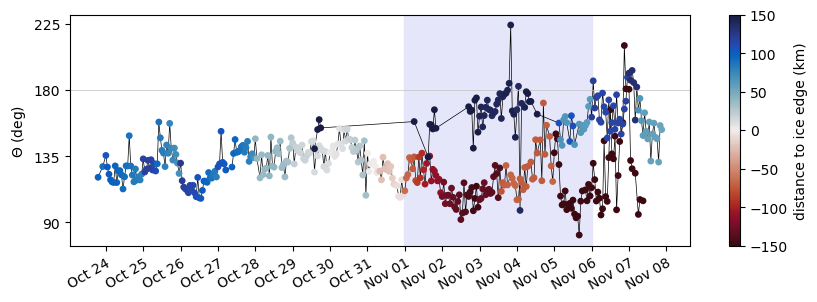

In [8]:
time_range = [np.datetime64('2019-10-31 23:30'),
              np.datetime64('2019-11-06 00:30')]

rc('font', size = 10)
plt.figure(figsize=(10,3))

cmap = cmo.balance_r
s = 15
vmin = -150
vmax = 150

time_series_scatter_plot(swift20_spring, 'timestamp', 'swell.meandirT', 'dist_meridian', 'valid_wave_direction',
        scale_c = 1e-3, vmin=vmin, vmax=vmax, cmap=cmap, s=s)
time_series_scatter_plot(swift21_spring, 'timestamp', 'swell.meandirT', 'dist_meridian', 'valid_wave_direction',
        scale_c = 1e-3, vmin=vmin, vmax=vmax, cmap=cmap, s=s)
mark_time_range(time_range)
mark_southward()
plt.colorbar(label='distance to ice edge (km)')
plt.ylabel('$\Theta$ (deg)')
nice_time_axis()

plt.savefig('../figures/swell_direction_time_series.png', dpi=300, bbox_inches='tight')

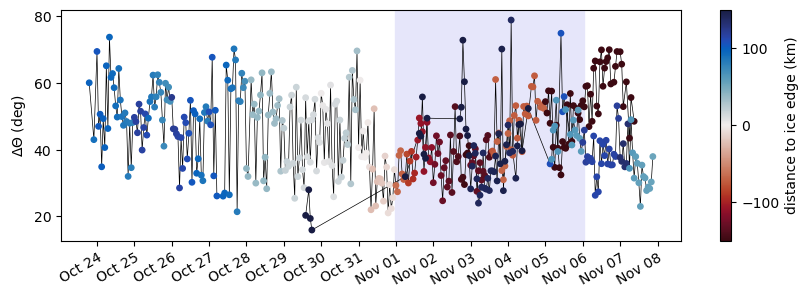

In [9]:
plt.figure(figsize=(10,3))

time_series_scatter_plot(swift20_spring, 'timestamp', 'swell.dirspread', 'dist_meridian', 'valid_wave_direction',
        scale_c = 1e-3, vmin=vmin, vmax=vmax, cmap=cmap, s=s)
time_series_scatter_plot(swift21_spring, 'timestamp', 'swell.dirspread', 'dist_meridian', 'valid_wave_direction',
        scale_c = 1e-3, vmin=vmin, vmax=vmax, cmap=cmap, s=s)
mark_time_range(time_range)
plt.colorbar(label='distance to ice edge (km)')
plt.ylabel('$\Delta \Theta$ (deg)')
nice_time_axis()

plt.savefig('../figures/directional_spread_time_series.png', dpi=300, bbox_inches='tight')
rc('font', size = 14)

## Comparing sea ice and open water
We now select a time period were we have data from both buoys and were the open water wave field looks relatively stable. Based on significant wave height of swell (Figure 4/notebook 04), the time period between Nov 1 and Nov 6 is a suitable choise.

In [10]:
swift_ice = swift21_spring[(swift21_spring['timestamp'] > time_range[0]) &
                              (swift21_spring['timestamp'] < time_range[1]) ]
swift_ow  = swift20_spring[(swift20_spring['timestamp'] > time_range[0]) &
                              (swift20_spring['timestamp'] < time_range[1]) ]

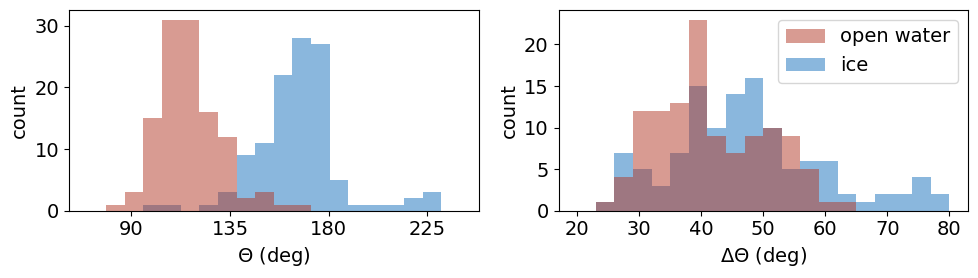

In [11]:
number_of_bins = 20
direction_range = (70, 240)
spread_range =(20,80)

ice_color = cmo.balance(0.2) #'skyblue'
ow_color  = cmo.balance(0.8) #'gray'
alpha = 0.5

plt.figure(figsize=(10,3))

plt.subplot(121)
swift_ow['swell.meandirT'].hist(bins = number_of_bins, 
                                range = direction_range,
                                color = ow_color,
                                alpha = alpha, 
                                grid = False,
                                label = 'open water')
swift_ice['swell.meandirT'].hist(bins = number_of_bins, 
                                 range = direction_range,
                                 color = ice_color,
                                 alpha = alpha, 
                                 grid = False,
                                 label = 'ice',
                                 zorder=-1)
plt.xlabel('$\Theta$ (deg)')
plt.ylabel('count')
plt.xticks(ticks=[90,135,180,225])
    
plt.subplot(122)
swift_ow['swell.dirspread'].hist(bins = number_of_bins, 
                                 range = spread_range,
                                 color = ow_color,
                                 alpha = alpha, 
                                 grid = False,
                                 label = 'open water')
swift_ice['swell.dirspread'].hist(bins = number_of_bins, 
                                  range = spread_range,
                                  color = ice_color,
                                  alpha = alpha, 
                                  grid = False,
                                  label = 'ice',
                                  zorder=-1)
plt.xlabel('$\Delta \Theta$ (deg)')
plt.ylabel('count')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../figures/direction_histogram.png', dpi=300)

Above is the mean swell direction and directional spread for the selected time period.

We also want polar plots of mean direction and spread per frequency bin, but we will do that using [SWIFT-codes](https://github.com/SASlabgroup/SWIFT-codes/blob/master/Waves/SWIFTdirectionalspectra.m). Therefore, we need to export the selected datapoints to matlab.

In [12]:
save_swift_as_mat_file(swift_ow, '../data/SWIFT_openwater.mat')
save_swift_as_mat_file(swift_ice, '../data/SWIFT_ice.mat')